In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from models import FlatNetwork, ConvNetwork, CombiModel
import sys
import pandas as pd
import json

def brier_score(preds, true):
    sum_score = 0
    for i in range(len(preds)):
        p = preds[i]
        t = true[i]
        sum_score += np.sum([(p[x]-t[x])**2 for x in range(len(p))])
    return sum_score/len(preds)

def create_dataset(xs, ys, n_classes):
  ys = tf.one_hot(ys, depth=n_classes)
  return tf.data.Dataset.from_tensor_slices((xs, ys)) \
    .shuffle(len(ys)) \
    .batch(128)

In [8]:
import db_handler
import importlib
importlib.reload(db_handler)
from db_handler import DataManager

seasons = [17]

train_seasons = [str(2000+int(arg)-1)+"/"+str(2000+int(arg)) for arg in seasons[:-1]]
val_seasons = [str(2000+int(seasons[-1])-1)+"/"+str(2000+int(seasons[-1]))]

print(train_seasons)
print(val_seasons)

data_handler = DataManager()
train_x, train_y, train_odds, train_teams = data_handler.buildData(train_seasons, regression=False)
val_x, val_y, val_odds, val_teams = data_handler.buildData(val_seasons, regression=False)

original_val_y = val_y
train_y = tf.one_hot(train_y, depth=3)
val_y = tf.one_hot(val_y, depth=3)

print(np.shape(train_x['layouts']))
print(np.shape(train_x['flats']))
print(np.shape(train_x['attrss']))
print(np.shape(train_y))

# scaler = StandardScaler()
# train_x['attrss'] = scaler.fit_transform(train_x['attrss'])
# val_x['attrss'] = scaler.transform(val_x['attrss'])

[]
['2016/2017']
---- test
England Premier League
Season:       season
0  2008/2009
1  2009/2010
2  2010/2011
3  2011/2012
4  2012/2013
5  2013/2014
6  2014/2015
7  2015/2016
Season not found
Season not found
Season not found
Season not found
Season not found
Season not found
Season not found
Season not found


ValueError: need at least one array to concatenate

In [157]:
model_config = {
    "flat" : {
        "dense_layers" : [{
            "nodes" : 64
        },
        {
            "nodes" : 32
        }]
    },
     "reg_features" : {
        "dense_layers" : [{
            "nodes" : 128
        },
        {
            "nodes" : 64
        }]
    },
    "square" : {
        "conv_layers" : [{
            "kernel_size" : [3,3],
            "kernels" : 16
        }],
        "dense_layers" : [{
            "nodes" : 64
        },
        {
            "nodes" : 32
        }]
    }
}

In [82]:
with open('model_config.json') as fp:
    config = json.load(fp)

model = CombiModel(config["square"],(9,22,1),(7,1),1, regression=True)
# model = FlatNetwork(config["flat"], input_shape=len(train_x['attrss'][0]), output_length=1, regression=True)
print(model.summary())

sgd_opt = tf.keras.optimizers.SGD(lr=0.0001, momentum=0.75, decay=0.0005/50, nesterov=False)
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
# model.compile(optimizer=adam_opt, 
#               loss=tf.losses.CategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
model.compile(optimizer=adam_opt, 
              loss='mse',
              metrics=['mse','mae'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    x=[train_x['layouts'], train_x['attrss']], y=train_y,
    # x=train_x['attrss'], y=train_y,
	validation_data=([val_x['layouts'], val_x['attrss']], val_y),
    # validation_data=(val_x['attrss'], val_y),
	epochs=25,
    steps_per_epoch=50,
    batch_size=16,
    callbacks=[tensorboard_callback])

val_preds = model.predict([val_x['layouts'], val_x['attrss']])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attrs (InputLayer)              [(None, 7, 1)]       0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 7, 64)        128         attrs[0][0]                      
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 7, 32)        2080        dense_9[0][0]                    
__________________________________________________________________________________________________
layouts (InputLayer)            [(None, 9, 22, 1)]   0                                            
____________________________________________________________________________________________

In [86]:
def check_result(pred, result):
    if pred < 0 and result < 0:
        return 1
    if pred > 0 and result > 0:
        return 1
    if pred == 0 and result == 0:
        return 1
    return 0

results = [check_result(val_preds[i], val_y[i]) for i in range(len(val_preds))]
print(np.mean(results))
print(len([pred for pred in val_preds if pred < 0]))
print(len([pred for pred in val_preds if pred > 0]))
print(len([pred for pred in val_preds if pred == 0]))

0.5388888888888889
117
243
0


In [161]:
import tensorflow_probability as tfp
import datetime
dist = tfp.distributions

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

dataset_size = len(train_x['flats'])
kl_divergence_function = (lambda q, p, _: dist.kl_divergence(q, p) / tf.cast(dataset_size, dtype=tf.float32))

model_tfp = tf.keras.Sequential([
    tf.keras.Input(shape=(len(train_x['flats'][0]),),name="basket"),
    tfp.layers.DenseFlipout(64, kernel_divergence_fn=kl_divergence_function, activation=tf.nn.leaky_relu, name="dense_tfp_1"),
    tfp.layers.DenseFlipout(32, kernel_divergence_fn=kl_divergence_function, activation=tf.nn.leaky_relu, name="dense_tfp_2"),
    tfp.layers.DenseFlipout(3, kernel_divergence_fn=kl_divergence_function, name="out_tfp_pred"),
])

learning_rate = 0.001

model_tfp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

batch_size = 5

scaler = StandardScaler()
sc_train_x = train_x
sc_val_x = val_x
sc_train_x['flats'] = scaler.fit_transform(train_x['flats'])
sc_val_x['flats'] = scaler.transform(val_x['flats'])

# scaler = StandardScaler()
# sc_train_y = train_y
# sc_val_y = val_y
# sc_train_y = scaler.fit_transform(train_y)
# sc_val_y = scaler.transform(val_y)

history = model_tfp.fit(x=sc_train_x['flats'], 
                    y=sc_train_y,
                    epochs=30, 
                    verbose=1, 
                    batch_size=batch_size,
                    validation_split=0.1,
                    validation_freq=5,
                    callbacks=[tensorboard_callback])

Epoch 1/30
336/336 [==============================] - 2s 1ms/step - loss: 4.6295 - accuracy: 0.2850
Epoch 2/30
336/336 [==============================] - 0s 1ms/step - loss: 3.6307 - accuracy: 0.3183
Epoch 3/30
336/336 [==============================] - 0s 1ms/step - loss: 2.0360 - accuracy: 0.3741
Epoch 4/30
336/336 [==============================] - 0s 1ms/step - loss: 4.0104 - accuracy: 0.4127
Epoch 5/30
336/336 [==============================] - 1s 2ms/step - loss: 2.1734 - accuracy: 0.3263 - val_loss: 4.5079 - val_accuracy: 0.3476
Epoch 6/30
336/336 [==============================] - 0s 1ms/step - loss: 6.5657 - accuracy: 0.3392
Epoch 7/30
336/336 [==============================] - 0s 1ms/step - loss: 4.7810 - accuracy: 0.3236
Epoch 8/30
336/336 [==============================] - 0s 1ms/step - loss: 4.2468 - accuracy: 0.2796
Epoch 9/30
336/336 [==============================] - 0s 1ms/step - loss: 4.8309 - accuracy: 0.3116
Epoch 10/30
336/336 [==============================] - 0s 

In [160]:
# preds = [[model_tfp.predict(np.expand_dims(val_flat, [0])) for i in range(100)] for val_flat in train_x['flats'][:10]]

array([-0.93299621, -0.58664797,  1.60922198])

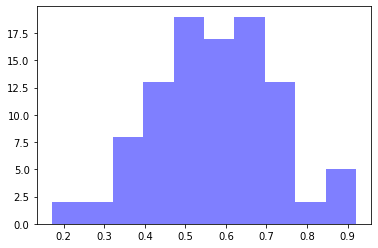

In [118]:
from matplotlib import pyplot as plt
# preds = np.array(preds)[:,0,:]
# max_preds = np.argmax(preds, axis=1)
# preds = [model_tfp.predict(np.expand_dims(val_x['flats'][0], [0])) for i in range(100)]
pred_0 = np.array([pred[i][0][0] for i in range(len(preds[0]))])
plt.hist(pred_0, 10, facecolor='blue', alpha=0.5)

# print(val_preds[1])
# print(np.mean(np.argmax(val_preds, axis=1)==np.argmax(val_y, axis=1)))
# preds = [preds[i][0][0] for i in range(len(preds))]
# results = np.array(results)
# plt.scatter(results[:,0], results[:,1])
plt.show()

In [114]:
    print(np.mean([np.mean(preds[i]).round() == val_y[i] for i in range(len(preds))]))

0.5333333333333333


In [154]:
for i in range(len(preds)):
    pred = scaler.inverse_transform(np.array(preds[i]))
    result = 1 if val_y[i] > 0 else 0 if val_y[i] == 0 else -1
    odds = val_odds[i]
    print(len(pred[pred>0])/len(pred), round(odds[0],2), result)

1.0 0.78 1
0.24 0.31 0
0.06 0.72 -1
0.0 0.39 -1
0.29 0.5 -1
0.73 0.43 0
0.98 0.26 -1
1.0 0.73 1
1.0 0.19 -1
0.21 0.11 -1
